In [118]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

from adaptvqe.pools import DVG_CEO
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [119]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

In [120]:
mol = pyscf.gto.Mole()
geom = of.chem.geometry_from_pubchem("water")
basis = "sto-3g"
symmetry = "C1"
multiplicity = 1
charge = 0
mol.build(
    atom=geom,
    basis=basis,
    symmetry=symmetry,
)

In [121]:
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

In [122]:
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
print(f"Molecule has {num_orbitals} orbitals.")
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -74.9644475827696
Molecule has 7 orbitals.
CASCI E = -75.0155301894367  E(CI) = -84.0998947014127  S^2 = 0.0000000


In [123]:
exact_energy

np.float64(-75.01553018943669)

## Get the Ansatz circuit

In [124]:
mol_of = MolecularData(geom, basis, multiplicity, charge, description='H2')
mol_of = run_pyscf(mol_of, run_fci=True, run_ccsd=True)
nelec = (num_elec_a, num_elec_b)
print(mol_of.n_orbitals)
print(mol_of.hf_energy)

7
-74.96444758276955


In [125]:
pool = DVG_CEO(mol_of)

max_mpo_bond = 200
adapt_mps_bond = 10
my_adapt = TensorNetAdapt(
    pool=pool,
    molecule=mol_of,
    max_adapt_iter=1,
    recycle_hessian=True,
    tetris=True,
    verbose=True,
    threshold=0.1,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)

my_adapt.initialize()

circuits = []
adapt_energies = []
for i in range(3):
    print(f"On iteration {i}.")
    my_adapt.run_iteration()
    data = my_adapt.data
    ansatz_circuit = pool.get_circuit(my_adapt.indices, my_adapt.coefficients)
    print("coefficients:", my_adapt.coefficients)
    print("indices:", my_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(2 * num_orbitals)
    circuit = QuantumCircuit(q)
    circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(my_adapt.energy)


tensor-net-adapt prepared with the following settings:
> Pool: DVG_CEO
> Molecule: H2 (interatomic distance r=0.2544Å)
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: True
> Tetris: True (progressive optimization: False)
> Convergence threshold (gradient norm):  0.1
> Maximum number of iterations:  1
> candidates per iteration:  1

Initial energy: -74.9637279779654
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 2436 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 4: -1.324298095852489e-06
Operator 5: -5.968985271523485e-08
Operator 10: -6.590324696752282e-05
Operator 11: 1.3840495044309517e-07
Operator 15: -7.49894195704975e-05
Operator 16: -2.8068657006670108e-06
Operator 20: 1.3127051151431979e-06
Operator 21: 2.3394783557796038e-06
Operator 24: -2.3435610992251222e-06
Operator 25: -5.732538592775893e-07
Operator 28: 2.0557306771630736e-06
Operator 2

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


         Current function value: -74.963728
         Iterations: 0
         Function evaluations: 52
         Gradient evaluations: 40

Current energy: -74.96372797796536
(change of 4.263256414560601e-14)
Current ansatz: [np.int64(2206), np.int64(1848)]
coefficients: [np.float64(0.0), np.float64(0.0)]
indices: [2206 1848]
On iteration 1.

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 2436 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 4: -1.3242980958631483e-06
Operator 5: -5.968985271523276e-08
Operator 10: -6.590324696756022e-05
Operator 11: 1.3840495044309326e-07
Operator 15: -7.498941957057034e-05
Operator 16: -2.8068657006670184e-06
Operator 20: 1.312705114621755e-06
Operator 21: 2.3394783557795987e-06
Operator 24: -2.3435610992251163e-06
Operator 25: -5.732538593484991e-07
Operator 28: 2.0557306771631265e-06
Operator 29: 2.110708793102712e-06
Operator 31: -0.00036277158546582004
Operator 32: -3.866164836659856e-07
Operator 34: 0.0

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


         Current function value: -74.980385
         Iterations: 16
         Function evaluations: 66
         Gradient evaluations: 55

Current energy: -74.98038510267877
(change of -0.016657124713404414)
Current ansatz: [np.int64(2206), np.int64(1848), np.int64(2206), np.int64(1848)]
coefficients: [np.float64(-0.041873235187469576), np.float64(-0.017100694281989154), np.float64(-0.04261592966526208), np.float64(-0.019227099615135582)]
indices: [2206 1848 2206 1848]
On iteration 2.

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 2436 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.0004990967443760483
Operator 4: -0.0007539291150237542
Operator 5: -5.9304209767756e-08
Operator 6: -0.0004980387198362281
Operator 10: 0.0006868400257996207
Operator 11: 1.3716690793744737e-07
Operator 12: -6.314366147173789e-08
Operator 13: 0.004568612993956754
Operator 15: 0.002525257819803828
Operator 16: -2.730546447512697e-06
Operator 17: 5.935741011

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


         Current function value: -74.985853
         Iterations: 1
         Function evaluations: 37
         Gradient evaluations: 28

Current energy: -74.98585274571843
(change of -0.005467643039665404)
Current ansatz: [np.int64(2206), np.int64(1848), np.int64(2206), np.int64(1848), np.int64(810), np.int64(811), np.int64(708), np.int64(709)]
coefficients: [np.float64(-0.04187074014513175), np.float64(-0.01708851563036787), np.float64(-0.04261382684962197), np.float64(-0.01921490558171982), np.float64(-0.0351761479812621), np.float64(-6.9883427689250024e-37), np.float64(-0.034984798463839784), np.float64(-5.217016672584949e-33)]
indices: [2206 1848 2206 1848  810  811  708  709]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


In [126]:
circuit = circuits[-1]
print(circuit)

         ┌───────────────────┐┌───┐┌───┐                          »
  q71_0: ┤0                  ├┤ X ├┤ H ├──────────────────────────»
         │                   │└─┬─┘├───┤┌───┐                ┌───┐»
  q71_1: ┤1                  ├──┼──┤ X ├┤ H ├────────────────┤ X ├»
         │                   │  │  └─┬─┘└───┘                └─┬─┘»
  q71_2: ┤2                  ├──┼────┼─────────────────────────┼──»
         │                   │  │    │                         │  »
  q71_3: ┤3                  ├──┼────┼─────────────────────────┼──»
         │                   │  │    │                         │  »
  q71_4: ┤4                  ├──┼────┼─────────────────────────┼──»
         │                   │  │    │                         │  »
  q71_5: ┤5                  ├──┼────┼─────────────────────────┼──»
         │                   │  │    │                         │  »
  q71_6: ┤6                  ├──┼────┼─────────────────────────┼──»
         │   Hartree_fock_jw │  │    │          

In [127]:
nq = circuit.num_qubits
print(f"Circuit has {nq} qubits.")

Circuit has 14 qubits.


In [128]:
for circuit in circuits:
    print(circuit.depth())

28
54
102


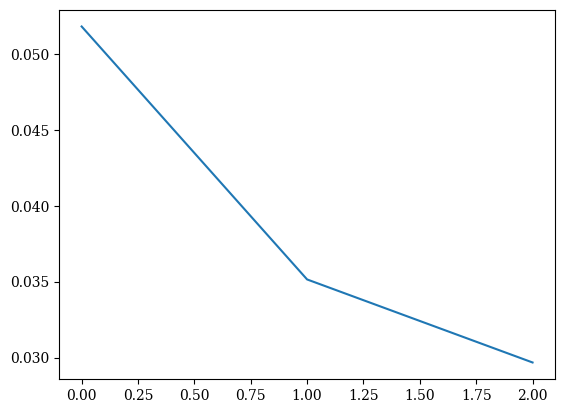

In [129]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))

In [130]:
## Sample shots from the circuit

In [131]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
to_run = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'cx': 172, 'rz': 102, 'sx': 58, 'measure': 14, 'x': 11, 'barrier': 7})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 174, 'rz': 102, 'sx': 58, 'measure': 14, 'x': 11, 'barrier': 7})


In [132]:
# Get the HF state for visualizing results.
q = QuantumRegister(2 * num_orbitals)
hf = QuantumCircuit(q)
hf.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
hf.measure_all()
hf = pass_manager.run(hf)

simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(hf, shots=1)
hf_bitstring = list(result.result().get_counts().keys())[0]
hf_bitstring

'00111110011111'

# Get counts

In [133]:
job = sampler.run([to_run], shots=30_000)

In [134]:
bit_array = job.result()[0].data.meas

In [135]:
print(type(bit_array))

<class 'qiskit.primitives.containers.bit_array.BitArray'>


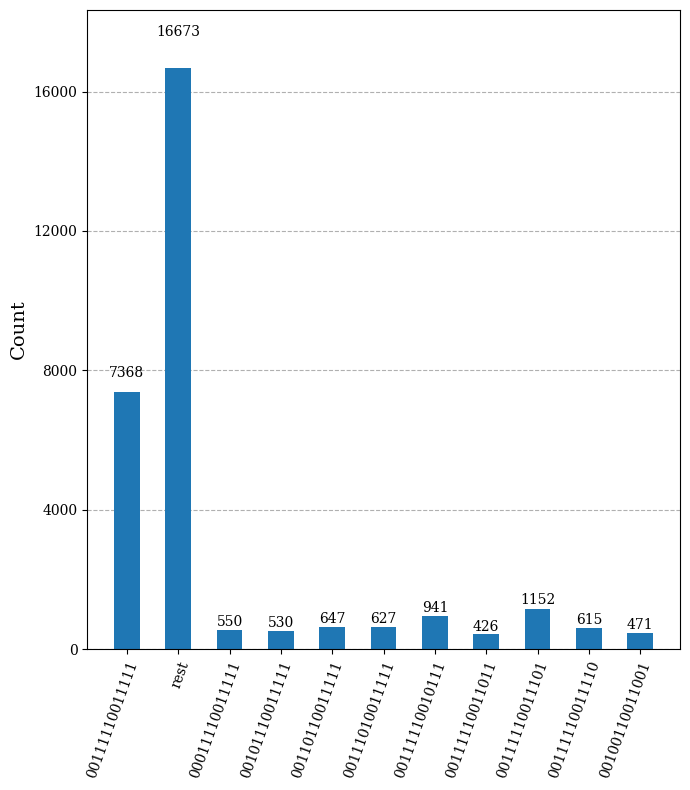

In [136]:
qiskit.visualization.plot_histogram(
    bit_array.get_counts(),
    target_string=hf_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    # ax=ax
    # filename="hf_ucj2.pdf",
)
# plt.tight_layout()
# plt.savefig("hf_ucj1.pdf")

## Post-process result.

In [137]:
bit_arrays = []
counts_list = []
for circuit in circuits:
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

Gate counts (w/ pre-init passes): OrderedDict({'measure': 14, 'x': 10, 'barrier': 3})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 107, 'rz': 77, 'sx': 54, 'measure': 14, 'x': 10, 'barrier': 5})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 172, 'rz': 102, 'sx': 58, 'measure': 14, 'x': 11, 'barrier': 7})


In [138]:
energies = []
errors = []

for bit_array in bit_arrays:
    # SQD options
    energy_tol = 1e-5
    occupancies_tol = 1e-6
    max_iterations = 20
    rng = np.random.default_rng(1)

    # Eigenstate solver options
    num_batches = 2
    samples_per_batch = 1000
    symmetrize_spin = True
    carryover_threshold = 1e-4
    max_cycle = 200

    # Pass options to the built-in eigensolver. If you just want to use the defaults,
    # you can omit this step, in which case you would not specify the sci_solver argument
    # in the call to diagonalize_fermionic_hamiltonian below.
    sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

    # List to capture intermediate results
    result_history = []


    def callback(results: list[SCIResult]):
        result_history.append(results)
        iteration = len(result_history)
        print(f"Iteration {iteration}")
        for i, result in enumerate(results):
            print(f"\tSubsample {i}")
            print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
            print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


    result = diagonalize_fermionic_hamiltonian(
        hcore,
        eri,
        bit_array,
        samples_per_batch=samples_per_batch,
        norb=num_orbitals,
        nelec=nelec,
        num_batches=num_batches,
        energy_tol=energy_tol,
        occupancies_tol=occupancies_tol,
        max_iterations=max_iterations,
        sci_solver=sci_solver,
        symmetrize_spin=symmetrize_spin,
        carryover_threshold=carryover_threshold,
        callback=callback,
        seed=rng,
    )

    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    approx_energy = min(min_e)
    err = abs(min(min_e) - exact_energy)
    print(approx_energy, err)
    energies.append(approx_energy)
    errors.append(err)

Iteration 1
	Subsample 0
		Energy: -75.01383746162067
		Subspace dimension: 121
	Subsample 1
		Energy: -75.01383746162067
		Subspace dimension: 121
Iteration 2
	Subsample 0
		Energy: -75.01383746162067
		Subspace dimension: 121
	Subsample 1
		Energy: -75.01383746162067
		Subspace dimension: 121
-75.01383746162067 0.0016927278160210335
Iteration 1
	Subsample 0
		Energy: -75.01383746162067
		Subspace dimension: 121
	Subsample 1
		Energy: -75.01383746162067
		Subspace dimension: 121
Iteration 2
	Subsample 0
		Energy: -75.01383773950236
		Subspace dimension: 169
	Subsample 1
		Energy: -75.01383773950236
		Subspace dimension: 169
-75.01383773950236 0.0016924499343247135
Iteration 1
	Subsample 0
		Energy: -75.01383755739185
		Subspace dimension: 144
	Subsample 1
		Energy: -75.01383755739185
		Subspace dimension: 144
Iteration 2
	Subsample 0
		Energy: -75.01389674251477
		Subspace dimension: 225
	Subsample 1
		Energy: -75.01389674251477
		Subspace dimension: 225
Iteration 3
	Subsample 0
		Ene

In [139]:
print(energies)
print(errors)

[np.float64(-75.01383746162067), np.float64(-75.01383773950236), np.float64(-75.01467958640798)]
[np.float64(0.0016927278160210335), np.float64(0.0016924499343247135), np.float64(0.0008506030287094291)]


Text(0, 0.5, 'Energy error')

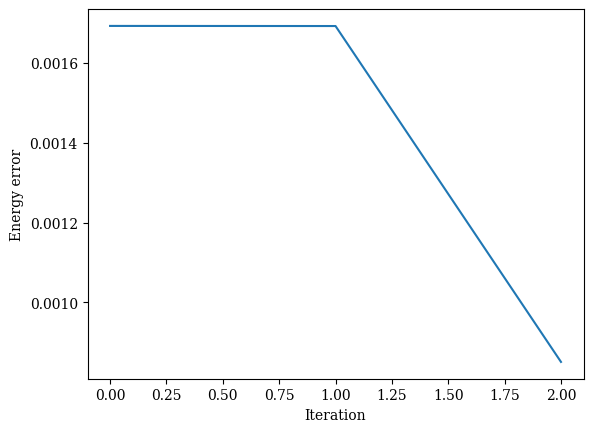

In [140]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate multiple rounds

Suppose we get bit arrays $B_1, B_2, \ldots, B_n$ from $n$ rounds of ADAPT. Run the SQD with the sequence of bit arrays $[B_1], [B_1, B_2], \ldots, [B_1, B_2, \ldots, B_n]$, where $[\cdot]$ denotes vertically concatenating arrays.

In [141]:
stacked_energies = []
stacked_errors = []

for i in range(1, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts)

    # SQD options
    energy_tol = 1e-5
    occupancies_tol = 1e-6
    max_iterations = 20
    rng = np.random.default_rng(1)

    # Eigenstate solver options
    num_batches = 2
    samples_per_batch = 1000
    symmetrize_spin = True
    carryover_threshold = 1e-4
    max_cycle = 200

    # Pass options to the built-in eigensolver. If you just want to use the defaults,
    # you can omit this step, in which case you would not specify the sci_solver argument
    # in the call to diagonalize_fermionic_hamiltonian below.
    sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

    # List to capture intermediate results
    result_history = []


    def callback(results: list[SCIResult]):
        result_history.append(results)
        iteration = len(result_history)
        print(f"Iteration {iteration}")
        for i, result in enumerate(results):
            print(f"\tSubsample {i}")
            print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
            print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


    result = diagonalize_fermionic_hamiltonian(
        hcore,
        eri,
        bit_array,
        samples_per_batch=samples_per_batch,
        norb=num_orbitals,
        nelec=nelec,
        num_batches=num_batches,
        energy_tol=energy_tol,
        occupancies_tol=occupancies_tol,
        max_iterations=max_iterations,
        sci_solver=sci_solver,
        symmetrize_spin=symmetrize_spin,
        carryover_threshold=carryover_threshold,
        callback=callback,
        seed=rng,
    )

    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    approx_energy = min(min_e)
    err = abs(min(min_e) - exact_energy)
    print(approx_energy, err)
    stacked_energies.append(approx_energy)
    stacked_errors.append(err)

Iteration 1
	Subsample 0
		Energy: -75.01383746162067
		Subspace dimension: 121
	Subsample 1
		Energy: -75.01383746162067
		Subspace dimension: 121
Iteration 2
	Subsample 0
		Energy: -75.01383746162067
		Subspace dimension: 121
	Subsample 1
		Energy: -75.01383746162067
		Subspace dimension: 121
-75.01383746162067 0.0016927278160210335
Iteration 1
	Subsample 0
		Energy: -75.01383746162067
		Subspace dimension: 121
	Subsample 1
		Energy: -75.01383746162067
		Subspace dimension: 121
Iteration 2
	Subsample 0
		Energy: -75.01383773950236
		Subspace dimension: 169
	Subsample 1
		Energy: -75.01383773950236
		Subspace dimension: 169
-75.01383773950236 0.0016924499343247135
Iteration 1
	Subsample 0
		Energy: -75.01383755739185
		Subspace dimension: 144
	Subsample 1
		Energy: -75.01383755739185
		Subspace dimension: 144
Iteration 2
	Subsample 0
		Energy: -75.01448405149794
		Subspace dimension: 256
	Subsample 1
		Energy: -75.01448405149794
		Subspace dimension: 256
Iteration 3
	Subsample 0
		Ene

In [142]:
print(energies)
print(errors)

[np.float64(-75.01383746162067), np.float64(-75.01383773950236), np.float64(-75.01467958640798)]
[np.float64(0.0016927278160210335), np.float64(0.0016924499343247135), np.float64(0.0008506030287094291)]


Text(0, 0.5, 'Energy error')

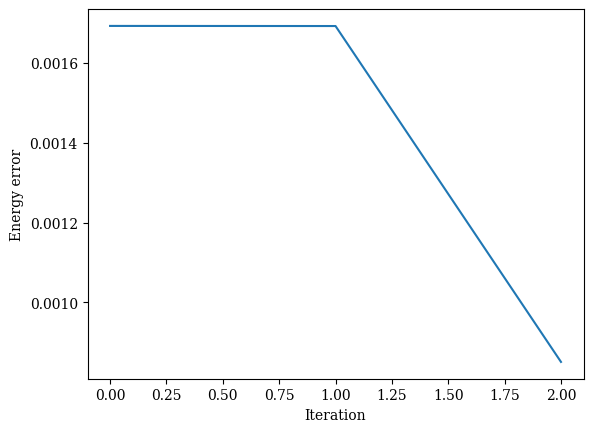

In [143]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

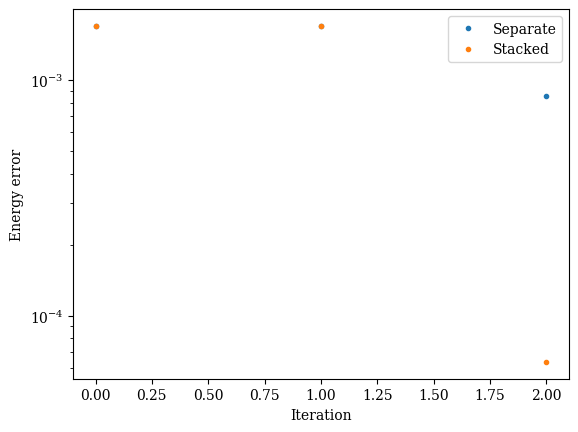

In [145]:
fig, ax = plt.subplots()
ax.plot(errors, '.', label="Separate")
ax.plot(stacked_errors, '.', label="Stacked")
ax.set_ylabel("Energy error")
ax.set_xlabel("Iteration")
ax.set_yscale("log")
ax.legend()